## 2022-02-18: Distribution of $m$-Blade Volumes in $\mathbb{R}^n$

*Last Updated*: 2022-02-18

### Authors
* Kevin Chu (kevin@velexi.com)

### Overview
In this Jupyter notebook, we explore the distribution of the volume of the blade defined by $m$ vectors independently drawn from a uniform distribution over a unit hypersphere in $\mathbb{R}^n$.

### Methodology

* Draw `num_samples` sets of $m$ vectors from a multivariate normal distribution with unit covariance matrix.

    * Using a multivariate normal distribution with diagonal covariance matrix (1) ensures that vectors are drawn uniformly over directions while (2) allowing us to treat each vector component as an independent random variable.
    
* For each sample $x_1, \ldots, x_m$, we perform the following computations to generate the volume distribution.

    * Normalize all of the vectors to have unit length.

    * Compute the $\vert x_1 \wedge \cdots \wedge x_m \vert$ by computing determinant of the $R$ matrix of the QR decomposition of the matrix $[x_1 | \cdots | x_m]$.

### User Parameters

* `num_samples`: number of samples to use for estimating probability distributions

* `n`: dimension of space

* `m`: dimension of blades to estimate probability distribution for

### Notes

* TODO

In [1]:
# --- User Parameters

# Number of samples to use to estimate probability distributions
num_samples = 1000;

In [2]:
# --- Imports

import Distributions
using Distributions: MvNormal, Uniform, ContinuousUnivariateDistribution, cdf, pdf
using HypothesisTests
using LinearAlgebra
using Plots
using Random
using StatsBase

In [3]:
# --- Internal Parameters

# ------ Uniformity test parameters

# p-value cutoff
p_value_cutoff = 0.1

# maximum number of attempts to generate a sample of vectors
max_attempts = 10

10

### Distributions in 2D

In [4]:
# --- Generate sample of vectors drawn from a uniform distribution on a unit circle

# Dimension of space
n_2d = 2;

# Blade dimension
m = 2;

# Set up uniformity tests
struct ThetaDistribution2D <: ContinuousUnivariateDistribution end
Distributions.cdf(dist::ThetaDistribution2D, x::Real) = 0.5 * (x + π) / π
theta_dist = ThetaDistribution2D()
AD_p_value = 0
KS_p_value = 0

# Generate sample of vectors
count = 0
vectors = undef
while ( ((AD_p_value < p_value_cutoff) || (KS_p_value < p_value_cutoff)) &&
        (count < max_attempts) )
    
    # Generate new sample
    dist = MvNormal(zeros(n_2d), ones(n_2d))
    num_vectors = num_samples * m
    vectors = rand(dist, num_vectors)
    for i = 1:num_vectors
        vectors[:, i] /= norm(vectors[:, i])
    end

    # Perform test for uniformity on unit circle
    thetas = map(i -> atan(vectors[:, i][2], vectors[:, i][1]), 1:num_vectors)

    # Anderson-Darling Test
    AD_p_value = pvalue(OneSampleADTest(thetas, theta_dist))

    # Kolmogorov-Smirnov Test
    KS_p_value = pvalue(ExactOneSampleKSTest(thetas, theta_dist))
    
    # Update count
    count += 1
end

# Display uniformity test results
if count < max_attempts
    println("Successfully generated sample")
    println("Samples generated to pass tests: $count")
    println("AD p-value: $AD_p_value")
    println("KS p-value: $KS_p_value")
else
    println("FAILED to generated sample with sufficient uniformity on unit circle")
end

Successfully generated sample
Samples generated to pass tests: 1
AD p-value: 0.11478675342121869
KS p-value: 0.11834636478750782


In [5]:
# --- Generate sample of blades

# Group vectors into blades
blades = []
for i = 1:num_samples
    push!(blades, vectors[:, (i-1)*m+1:i*m])
end

In [6]:
# --- Compute blade volumes

signed_volumes = Vector{Float64}()
for i = 1:num_samples
    F = qr(blades[i])
    signed_volume = det(F.R)
    push!(signed_volumes, signed_volume)
end

volumes = abs.(signed_volumes);

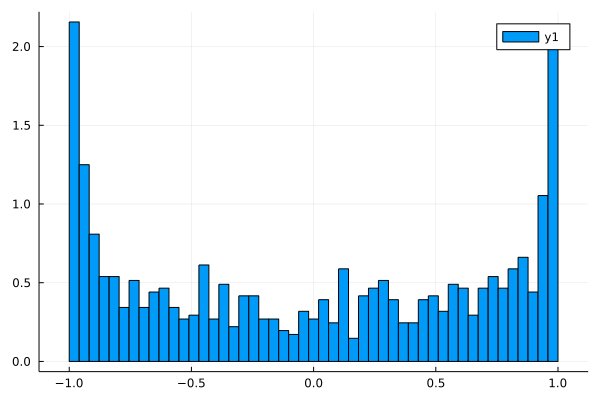

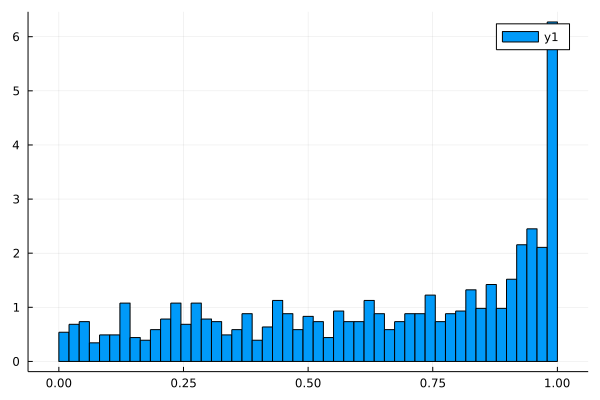

In [7]:
# --- Generate volume distributions

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins_signed = range(-1, 1; length=num_hist_bins)
plt_signed = plot(histogram(signed_volumes; bins=hist_bins_signed, normalize=true))

hist_bins = range(0, 1; length=num_hist_bins)
plt = plot(histogram(volumes; bins=hist_bins, normalize=true))

display(plt_signed)
display(plt)

# Compute empirical volume distributions
hist_signed = fit(Histogram, signed_volumes; nbins=num_hist_bins)
edf_signed = normalize(hist_signed; mode=:pdf);

hist = fit(Histogram, volumes; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);

### Distributions in 3D

In [8]:
# --- Generate sample of vectors drawn from a uniform distribution on a unit sphere

# Dimension of space
n_3d = 3;

# Blade dimension
m = 2;

# Set up uniformity tests
struct ThetaDistribution3D <: ContinuousUnivariateDistribution end
Distributions.cdf(dist::ThetaDistribution3D, x::Real) = 0.5 * (1 - cos(x))
theta_dist = ThetaDistribution3D()
AD_p_value = 0
KS_p_value = 0

# Generate sample of vectors
count = 0
vectors = undef
while ( ((AD_p_value < p_value_cutoff) || (KS_p_value < p_value_cutoff)) &&
        (count < max_attempts) )
    
    # Generate new sample
    dist = MvNormal(zeros(n_3d), ones(n_3d))
    num_vectors = num_samples * m
    vectors = rand(dist, num_vectors)
    for i = 1:num_vectors
        vectors[:, i] /= norm(vectors[:, i])
    end

    # Perform test for uniformity on unit circle
    thetas = map(i -> atan(norm(vectors[:, i][2:end]), vectors[:, i][1]), 1:num_vectors)

    # Anderson-Darling Test
    AD_p_value = pvalue(OneSampleADTest(thetas, theta_dist))

    # Kolmogorov-Smirnov Test
    KS_p_value = pvalue(ExactOneSampleKSTest(thetas, theta_dist))
    
    # Update count
    count += 1
end

# Display uniformity test results
if count < max_attempts
    println("Successfully generated sample")
    println("Samples generated to pass tests: $count")
    println("AD p-value: $AD_p_value")
    println("KS p-value: $KS_p_value")
else
    println("FAILED to generated sample with sufficient uniformity on unit sphere")
end

Successfully generated sample
Samples generated to pass tests: 1
AD p-value: 0.6240128001014006
KS p-value: 0.4786843886947417


In [9]:
# --- Generate sample of blades

# Group vectors into blades
blades = []
for i = 1:num_samples
    push!(blades, vectors[:, (i-1)*m+1:i*m])
end

In [10]:
# --- Compute blade volumes

signed_volumes = Vector{Float64}()
for i = 1:num_samples
    F = qr(blades[i])
    signed_volume = det(F.R)
    push!(signed_volumes, signed_volume)
end

volumes = abs.(signed_volumes);

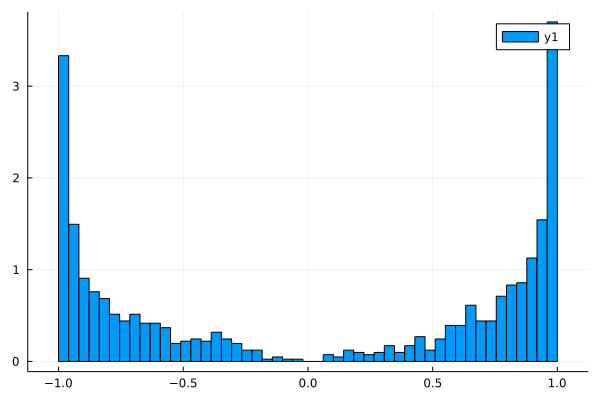

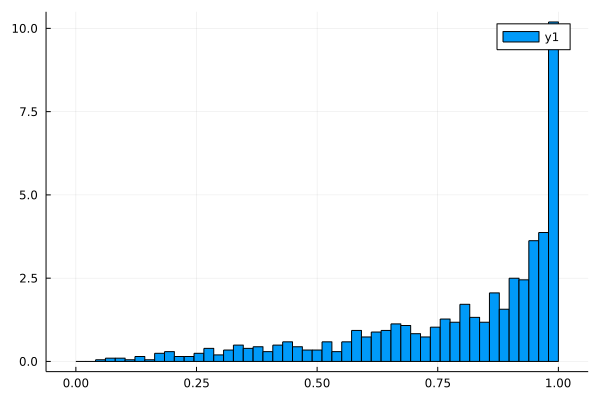

In [11]:
# --- Generate volume distributions

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins_signed = range(-1, 1; length=num_hist_bins)
plt_signed = plot(histogram(signed_volumes; bins=hist_bins_signed, normalize=true))

hist_bins = range(0, 1; length=num_hist_bins)
plt = plot(histogram(volumes; bins=hist_bins, normalize=true))

display(plt_signed)
display(plt)

# Compute empirical volume distributions
hist_signed = fit(Histogram, signed_volumes; nbins=num_hist_bins)
edf_signed = normalize(hist_signed; mode=:pdf);

hist = fit(Histogram, volumes; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);

### Distributions in Arbitrary Dimensions

In [12]:
# --- Generate sample of vectors drawn from a uniform distribution on a unit hypersphere

# Dimension of space
n = 100;

# Blade dimension
m = 2;

# Set up uniformity tests
struct ThetaDistributionND <: ContinuousUnivariateDistribution end
if n % 2 == 0
    function Distributions.cdf(dist::ThetaDistributionND, x::Real)
        k = n-2
        sgn = (-1)^(k÷2)
        value = 0
        for j = 0:(k÷2 - 1)
            value += (-1)^j * binomial(big(k), j) * sin((k - 2*j) * x) / (k - 2*j)
        end
        value *= 2
        value += sgn * binomial(big(k), k÷2) * x  # contribution from i = k÷2 term
        value *= sgn / π / binomial(big(k), k÷2)

        return value
    end
else
    function Distributions.cdf(dist::ThetaDistributionND, x::Real)
        k = n-2
        value = 0
        normalization = 0
        for j = 0:k
            coef = (-1)^j * binomial(big(k), j) / (k - 2*j)
            value += coef * (1 - cos((k - 2*j) * x))
            normalization += coef
        end
        normalization = 0.5 / normalization
        value *= normalization

        return value
    end
end
theta_dist = ThetaDistributionND()
AD_p_value = 0
KS_p_value = 0

# Generate sample of vectors
count = 0
vectors = undef
while ( ((AD_p_value < p_value_cutoff) || (KS_p_value < p_value_cutoff)) &&
        (count < max_attempts) )
    
    # Generate new sample
    dist = MvNormal(zeros(n), ones(n))
    num_vectors = num_samples * m
    vectors = rand(dist, num_vectors)
    for i = 1:num_vectors
        vectors[:, i] /= norm(vectors[:, i])
    end

    # Perform test for uniformity on unit circle
    thetas = map(i -> atan(norm(vectors[:, i][2:end]), vectors[:, i][1]), 1:num_vectors)

    # Anderson-Darling Test
    AD_p_value = pvalue(OneSampleADTest(thetas, theta_dist))

    # Kolmogorov-Smirnov Test
    KS_p_value = pvalue(ExactOneSampleKSTest(thetas, theta_dist))
    
    # Update count
    count += 1
end

# Display uniformity test results
if count < max_attempts
    println("Successfully generated sample")
    println("Samples generated to pass tests: $count")
    println("AD p-value: $AD_p_value")
    println("KS p-value: $KS_p_value")
else
    println("FAILED to generated sample with sufficient uniformity on unit hypersphere")
end

Successfully generated sample
Samples generated to pass tests: 2
AD p-value: 0.9621000327704332
KS p-value: 0.8796111939793886


In [13]:
# --- Generate sample of blades

# Group vectors into blades
blades = []
for i = 1:num_samples
    push!(blades, vectors[:, (i-1)*m+1:i*m])
end

In [14]:
# --- Compute blade volumes

signed_volumes = Vector{Float64}()
for i = 1:num_samples
    F = qr(blades[i])
    signed_volume = det(F.R)
    push!(signed_volumes, signed_volume)
end

volumes = abs.(signed_volumes);

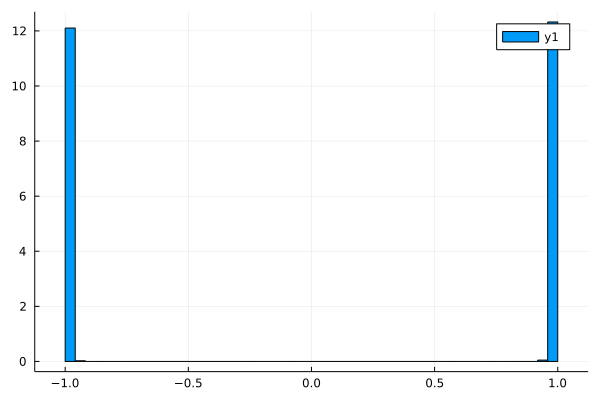

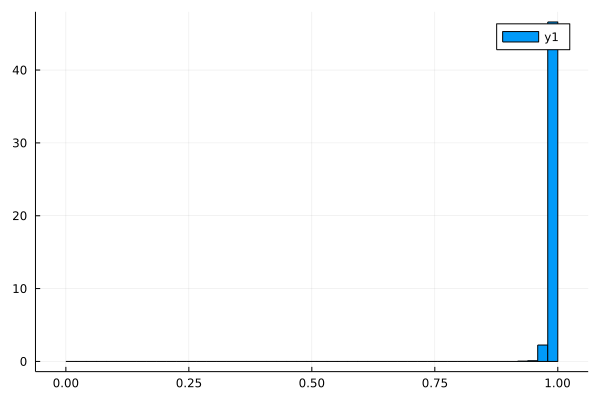

In [15]:
# --- Generate volume distributions

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins_signed = range(-1, 1; length=num_hist_bins)
plt_signed = plot(histogram(signed_volumes; bins=hist_bins_signed, normalize=true))

hist_bins = range(0, 1; length=num_hist_bins)
plt = plot(histogram(volumes; bins=hist_bins, normalize=true))
display(plt_signed)
display(plt)

# Compute empirical volume distributions
hist_signed = fit(Histogram, signed_volumes; nbins=num_hist_bins)
edf_signed = normalize(hist_signed; mode=:pdf);

hist = fit(Histogram, volumes; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);